In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np
from keras import models, layers
from sklearn.metrics import classification_report, f1_score

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS = 3
EPOCHS = 50
INPUT_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
CLASS_NAMES = ['Crack detected', 'Pothole', 'Surface erosion']
N_CLASSES = len(CLASS_NAMES)

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    'E:\python\ML\pothole_detection_CNN\Datasetv2',
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1284 files belonging to 3 classes.


<>:2: SyntaxWarning: invalid escape sequence '\p'
<>:2: SyntaxWarning: invalid escape sequence '\p'
C:\Users\DCL\AppData\Local\Temp\ipykernel_3100\1970459322.py:2: SyntaxWarning: invalid escape sequence '\p'
  'E:\python\ML\pothole_detection_CNN\Datasetv2',


In [4]:
class_names = dataset.class_names
class_names

['Crack', 'Pothole', 'Surface Erosion']

In [5]:
len(dataset)

41

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[2 1 1 0 2 1 2 1 1 2 0 1 0 0 1 0 0 2 0 1 2 0 2 0 2 1 1 1 2 1 0 0]


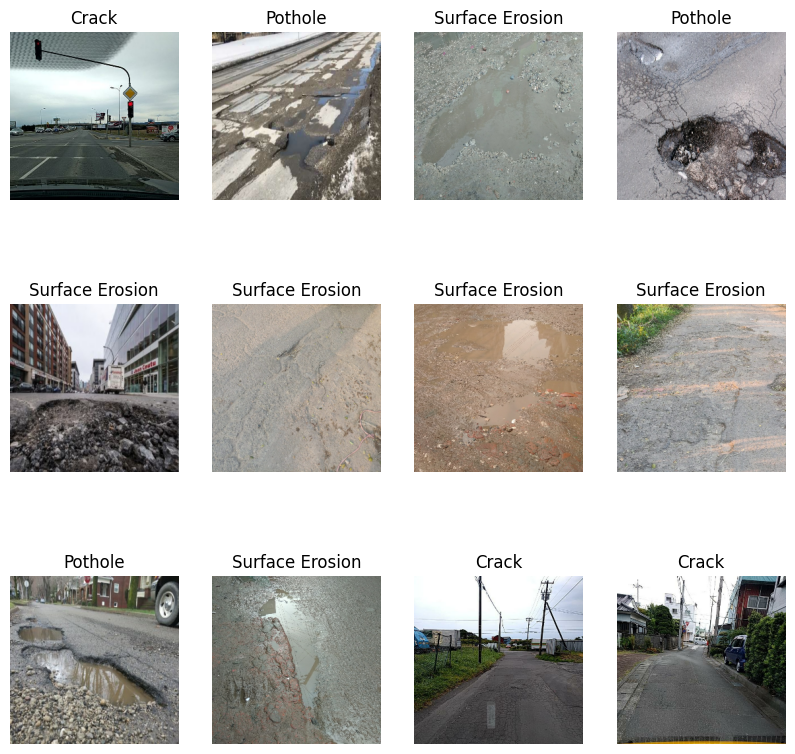

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [8]:
def partition_data(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds  = ds.shuffle(shuffle_size, seed = 12)
    train_size = int(train_split * ds_size)
    validation_size = int(val_split * ds_size)
    
    train_data = ds.take(train_size)
    
    validation_data = ds.skip(train_size).take(validation_size)
    test_data = ds.skip(train_size).skip(validation_size)
    return train_data, validation_data, test_data

train_data, validation_data, test_data = partition_data(dataset)
print(f"Training data size: {len(train_data)}")
print(f"Validation data size: {len(validation_data)}")
print(f"Test data size: {len(test_data)}")

Training data size: 32
Validation data size: 4
Test data size: 5


In [9]:
def prepare(ds):
    return ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data = prepare(train_data)
validation_data = prepare(validation_data)
test_data = prepare(test_data)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomContrast(0.2)
])

In [12]:
def build_efficientnet_model():
    base = tf.keras.applications.EfficientNetB0(include_top=False, input_shape=INPUT_SHAPE, weights='imagenet')
    base.trainable = False
    model = models.Sequential([
        resize_and_rescale,
        data_augmentation,
        base,
        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        # layers.Dropout(0.3),
        layers.Dense(N_CLASSES, activation='softmax')
    ])
    return model

In [13]:
model = build_efficientnet_model()

In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 8, 8, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,049,571 (15.45 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 4,049,571 (15.45 MB)

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
# Train model
history = model.fit(
    train_data,
    epochs=EPOCHS,
    validation_data=validation_data
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 49s 1s/step - accuracy: 0.3478 - loss: 1.1403 - val_accuracy: 0.3047 - val_loss: 1.1427
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3333 - loss: 1.1232 - val_accuracy: 0.3047 - val_loss: 1.1212
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3386 - loss: 1.1172 - val_accuracy: 0.3281 - val_loss: 1.1026
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3752 - loss: 1.1081 - val_accuracy: 0.3672 - val_loss: 1.0930
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3593 - loss: 1.1051 - val_accuracy: 0.3672 - val_loss: 1.0974
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3367 - loss: 1.1057 - val_accuracy: 0.3047 - val_loss: 1.1108
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4185 - loss: 1.0862 - val_accuracy: 0.3672 - val_loss: 1.1012
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3553 - loss: 1.1039 - val_accuracy: 0.3047 - val_loss:

In [17]:
scores = model.evaluate(test_data)
scores

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 896ms/step - accuracy: 0.5390 - loss: 1.0906


[1.0898687839508057, 0.5375000238418579]

In [18]:
model.save("Trained Modelv2/EfficientNetv1.o.h5")
model.save("Trained Modelv2/EfficientNetv1.o.keras")

In [19]:
history.params

{'verbose': 'auto', 'epochs': 50, 'steps': 32}

In [20]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [21]:
history.history['accuracy']

[0.3564257025718689,
 0.3393574357032776,
 0.336345374584198,
 0.3504016101360321,
 0.3423694670200348,
 0.36044177412986755,
 0.39156627655029297,
 0.3614457845687866,
 0.3333333432674408,
 0.35843372344970703,
 0.327309250831604,
 0.36646586656570435,
 0.3534136414527893,
 0.3765060305595398,
 0.3765060305595398,
 0.37248995900154114,
 0.3935742974281311,
 0.3674698770046234,
 0.35140562057495117,
 0.3564257025718689,
 0.3453815281391144,
 0.37248995900154114,
 0.379518061876297,
 0.3504016101360321,
 0.3674698770046234,
 0.37148594856262207,
 0.3423694670200348,
 0.37851405143737793,
 0.35542169213294983,
 0.3564257025718689,
 0.3755020201206207,
 0.3765060305595398,
 0.3734939694404602,
 0.3674698770046234,
 0.3765060305595398,
 0.370481938123703,
 0.40060240030288696,
 0.3614457845687866,
 0.3855421543121338,
 0.3755020201206207,
 0.3825301229953766,
 0.3885542154312134,
 0.4016064405441284,
 0.39257028698921204,
 0.3885542154312134,
 0.3423694670200348,
 0.4086345434188843,
 0.37

In [22]:
# Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in test_data:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

# Calculate F1 score (macro, weighted, etc.)
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))
print("F1 Score (weighted):", f1_score(y_true, y_pred, average='weighted'))

# Optional: Full classification report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 846ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 865ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 826ms/step
F1 Score (macro): 0.4199623352165725
F1 Score (weighted): 0.43771186440677967

Classification Report:

                 precision    recall  f1-score   support

          Crack       0.55      0.65      0.59        54
        Pothole       0.00      0.00      0.00        49
Surface Erosion       0.53      0.89      0.67        57

       accuracy                           0.54       160
      macro avg       0.36      0.51      0.42       160
   weighted avg       0.37      0.54      0.44       160



e:\python\ML\pothole_detection_CNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\python\ML\pothole_detection_CNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
e:\python\ML\pothole_detection_CNN\venv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(resu

In [23]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

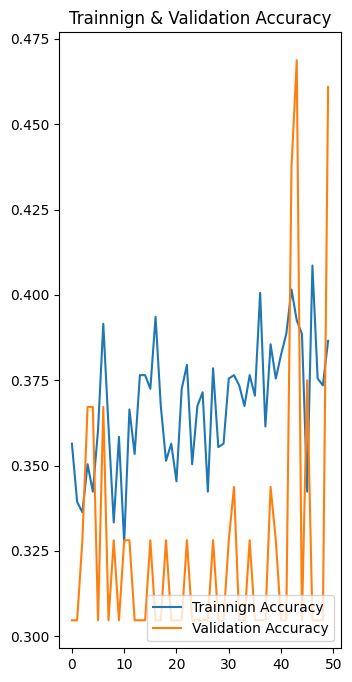

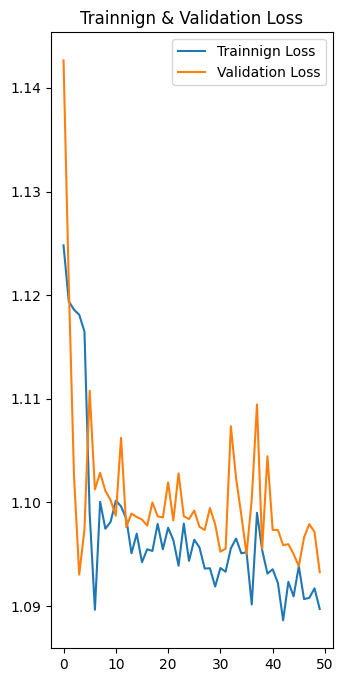

In [24]:

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), accuracy, label = "Trainnign Accuracy")
plt.plot(range(EPOCHS), val_accuracy, label = "Validation Accuracy")
plt.legend(loc = 'lower right')
plt.title("Trainnign & Validation Accuracy")

plt.figure(figsize = (8,8))
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = "Trainnign Loss")
plt.plot(range(EPOCHS), val_loss, label = "Validation Loss")
plt.legend(loc = 'upper right')
plt.title("Trainnign & Validation Loss")
plt.show()

In [25]:
model.evaluate(test_data)

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 963ms/step - accuracy: 0.5516 - loss: 1.0889


[1.0898687839508057, 0.5375000238418579]

First image to predict
First image actual label:  Crack
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 973ms/step
Predicted Label:  Surface Erosion


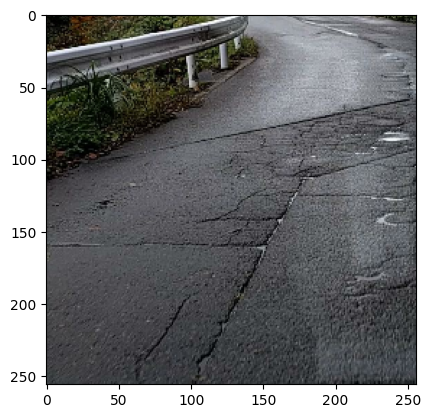

In [26]:
import numpy as np
for image_batch, label_batch in test_data.take(1):
    first_image = (image_batch[0].numpy().astype('uint8'))
    first_label = label_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("First image actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])

In [27]:
def predict(model, img):
    # Expand image dims and predict
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array_expanded = tf.expand_dims(img_array, 0)
    prediction = model.predict(img_array_expanded, verbose=0)

    predicted_class = class_names[np.argmax(prediction[0])]
    confidence = round(100 * (np.max(prediction[0])), 2)

    # Lighting detection
    grayscale_img = tf.image.rgb_to_grayscale(img_array)
    brightness = tf.reduce_mean(grayscale_img).numpy()

    if brightness < 100:
        lighting = "Low light"
    elif brightness > 180:
        lighting = "High light"
    else:
        lighting = "Normal lighting"

    return predicted_class, confidence, lighting

Confidence:->34.060001373291016 Light:-> Low light
Confidence:->34.13999938964844 Light:-> Normal lighting
Confidence:->33.9900016784668 Light:-> Normal lighting
Confidence:->34.65999984741211 Light:-> Normal lighting
Confidence:->34.11000061035156 Light:-> Low light
Confidence:->34.0 Light:-> Low light
Confidence:->34.65999984741211 Light:-> Normal lighting
Confidence:->34.4900016784668 Light:-> Normal lighting
Confidence:->34.04999923706055 Light:-> Normal lighting


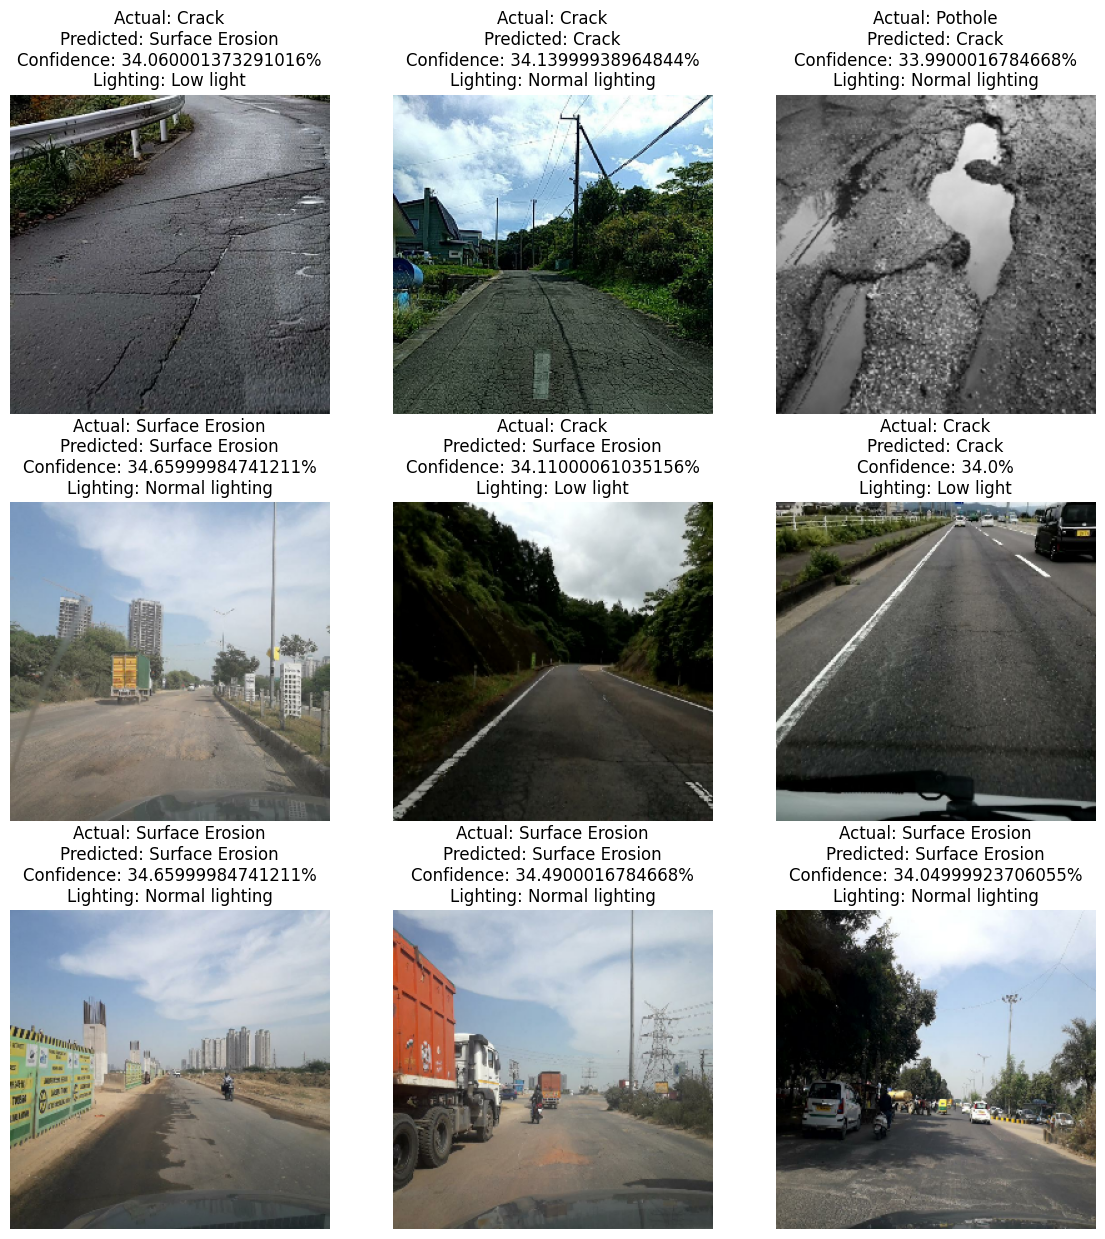

In [28]:
plt.figure(figsize=(14, 15))
for images, labels in test_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        img = images[i].numpy().astype("uint8")
        plt.imshow(img)

        predicted_class, confidence, lighting = predict(model, img)
        actual_class = class_names[labels[i]]
        print(f"Confidence:->{confidence} Light:-> {lighting}")
        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%\nLighting: {lighting}")
        plt.axis("off")

In [29]:
confidence_threshold = 0.8
if confidence >= confidence_threshold:
    print(f"Prediction: {predicted_class}, Confidence: {confidence}")
else:
    print("Prediction confidence is too low.")


Prediction: Surface Erosion, Confidence: 34.04999923706055


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 873ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 847ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step


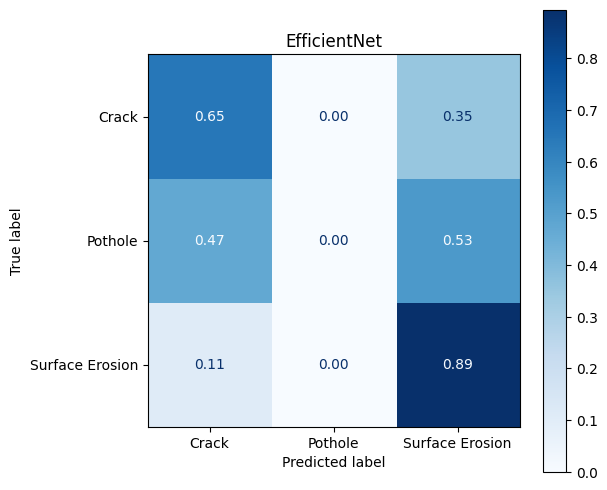

In [31]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []

for images, labels in test_data:
    predictions = model.predict(images)

    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("EfficientNet")
plt.savefig("Confusion Matrx/EfficientNet.png", dpi=300, bbox_inches='tight')
plt.show()


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
class_names = ['Crack', 'Pothole', 'Surface Erosion'] 
y_true = []
y_pred = []
for images, labels in test_data:
    predictions = model.predict(images)
    # If labels are integer-encoded (not one-hot)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=class_names)
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues, values_format=".2f")
plt.title("EfficientNetv1.o")
plt.savefig("Confusion Matrx/EfficientNetv1.o.png", dpi=300, bbox_inches='tight')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 944ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 949ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 912ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 862ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 863ms/step


MemoryError: Unable to allocate 1.19 MiB for an array with shape (1116, 1116) and data type bool

MemoryError: Unable to allocate 1.06 MiB for an array with shape (372, 373) and data type int64

<Figure size 600x600 with 2 Axes>